In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import AffineTransform
import vedo

from histalign.backend.ccf.paths import get_annotation_path
from histalign.backend.io import load_alignment_settings, load_image, load_volume
from histalign.backend.maths import get_transformation_matrix_from_q_transform
from histalign.backend.models import (
    AlignmentSettings,
    Resolution,
    upscale_alignment_settings,
)
from histalign.backend.registration import recreate_q_transform_from_alignment
from histalign.backend.workspace import AnnotationVolume, VolumeSlicer
from PIL import Image

vedo.settings.default_backend = "vtk"

In [2]:
def imshow(image: np.ndarray) -> None:
    _ = plt.figure()

    plt.imshow(image)
    plt.axis(False)

    plt.show()


def show(volume: vedo.Volume) -> None:
    vedo.show(volume, interactive=False).interactive().close()


def get_volume_scaling_factor(settings: AlignmentSettings) -> float:
    return (
        settings.volume_scaling / settings.histology_scaling
    ) * settings.histology_downsampling


def rescale(
    image: np.ndarray, scaling: float, fast: bool, interpolation: str
) -> np.ndarray:
    # NOTE: PIL's resize is much faster but less accurate.
    #       However, it is appropriate for masks.
    match interpolation:
        case "nearest":
            resample = Image.Resampling.NEAREST
            order = 0
        case "bilinear":
            resample = Image.Resampling.BILINEAR
            order = 1
        case _:
            raise ValueError(f"Unknown interpolation '{interpolation}'")

    if fast:
        return np.array(
            Image.fromarray(image.T).resize(
                np.round(np.array(image.shape) * scaling).astype(int).tolist(),
                resample=resample,
            )
        ).T
    else:
        return sk_rescale(
            image,
            scaling,
            preserve_range=True,
            clip=True,
            order=order,
        ).astype(image.dtype)


def transform_image(
    image: np.ndarray,
    alignment_settings: AlignmentSettings,
    fast: bool,
    interpolation: str,
    forward: bool = True,
) -> np.ndarray:
    q_transform = recreate_q_transform_from_alignment(
        image.shape, alignment_settings, forward
    )
    matrix = get_transformation_matrix_from_q_transform(q_transform, forward)

    match interpolation:
        case "nearest":
            flag = cv2.INTER_NEAREST
            order = 0
        case "bilinear":
            flag = cv2.INTER_LINEAR
            order = 1
        case _:
            raise ValueError(f"Unknown interpolation '{interpolation}'")

    # NOTE: OpenCV's warp is much faster but seemingly less accurate
    if fast:
        return cv2.warpPerspective(
            image,
            matrix,
            image.shape[::-1],
            flags=flag | cv2.WARP_INVERSE_MAP,
        )
    else:
        sk_transform = AffineTransform(matrix=matrix)
        return warp(
            image, sk_transform, order=order, preserve_range=True, clip=True
        ).astype(image.dtype)

In [3]:
# alignment_path = "/home/ediun/git/histalign/projects/unix/3cc119b7ec/2801232004be0a9958c7a5a6b0b2de83.json"
alignment_path = "/home/ediun/git/histalign/projects/conversion100/12c22ee785/c1e4a6b68b289dfce5bbd2d54cf24550.json"
alignment_settings = load_alignment_settings(alignment_path)

image = load_image(alignment_settings.histology_path)

### Get the normal registration

In [4]:
alignment_settings = load_alignment_settings(alignment_path)

In [5]:
annotation_volume = AnnotationVolume(
    get_annotation_path(alignment_settings.volume_settings.resolution),
    alignment_settings.volume_settings.resolution,
)

In [6]:
annotation_slicer = VolumeSlicer(volume=annotation_volume)

In [7]:
annotation_slice = annotation_slicer.slice(alignment_settings.volume_settings)

In [8]:
volume_final_scaling = get_volume_scaling_factor(alignment_settings)

annotation_slice = rescale(
    annotation_slice,
    volume_final_scaling,
    fast=True,
    interpolation="nearest",
)

In [9]:
annotation_slice = transform_image(
    annotation_slice,
    alignment_settings,
    fast=True,
    interpolation="nearest",
    forward=False,
)

### Get the upscaled registration

In [10]:
upscaled_settings = upscale_alignment_settings(
    alignment_settings, Resolution.MICRONS_25
)
# upscaled_settings.volume_scaling = 2.1431870066974596
# upscaled_settings.histology_scaling = 0.25662744046954114

In [11]:
upscaled_volume = AnnotationVolume(
    get_annotation_path(upscaled_settings.volume_settings.resolution),
    upscaled_settings.volume_settings.resolution,
)

In [12]:
upscaled_slicer = VolumeSlicer(volume=upscaled_volume)

In [13]:
upscaled_slice = upscaled_slicer.slice(upscaled_settings.volume_settings)

In [14]:
volume_final_scaling = get_volume_scaling_factor(upscaled_settings)

upscaled_slice = rescale(
    upscaled_slice,
    volume_final_scaling,
    fast=True,
    interpolation="nearest",
)

In [15]:
upscaled_slice = transform_image(
    upscaled_slice,
    upscaled_settings,
    fast=True,
    interpolation="nearest",
    forward=False,
)

### Visualise

In [16]:
print(image.shape)
print(annotation_slice.shape)
print(upscaled_slice.shape)

(7619, 9413)
(12484, 9414)
(12509, 9388)


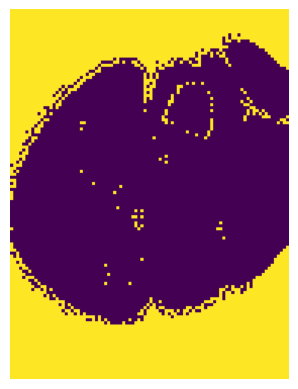

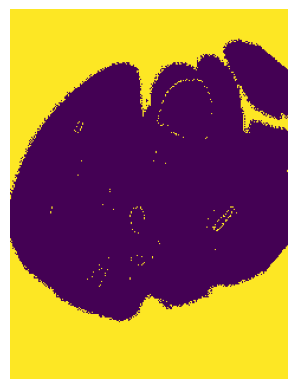

In [17]:
imshow(annotation_slice[::10, ::10] == 0)
imshow(upscaled_slice[::40, ::40] == 0)

In [18]:
plt.imsave("annotation.png", annotation_slice)
plt.imsave("upscaled.png", upscaled_slice)

In [19]:
plt.imsave("100.png", annotation_volume.tonumpy()[..., 40])
plt.imsave("25.png", upscaled_volume.tonumpy()[::4, ::4, 160])

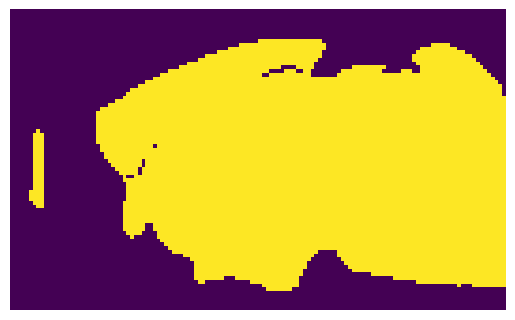

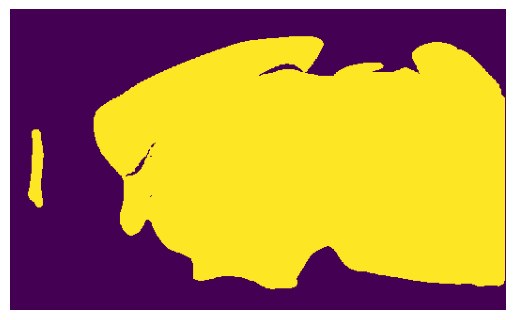

In [20]:
imshow(annotation_volume.tonumpy()[..., annotation_volume.shape[2] // 2].T > 0)
imshow(upscaled_volume.tonumpy()[..., upscaled_volume.shape[2] // 2].T > 0)